## Angular Reconstruction, Energy Inference & Cosmic Ray Classification

In [1]:
import os
import json
import pickle
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks, optimizers, Input, Model
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Optional

In [2]:
# ----------------------------- #
# Configuración reproducible    #
# ----------------------------- #
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

os.environ.setdefault("TF_GPU_ALLOCATOR", "cuda_malloc_async")
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass
if gpus:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [3]:
# ----------------------------- #
# Paths y parámetros del flujo  #
# ----------------------------- #
BASE_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CORSIKA-CONDOR-DATASETS")
CACHE_FILE = BASE_DIR / "processed_all_data.pkl"

ARTIFACTS_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

ENERGY_FILTER = ("3E2", "5E2", "8E2")
ANGLE_MAX = 40.0
MIN_TOTAL_PARTICLES = 30

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15  # test será 0.15 (restante)
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
# ----------------------------- #
# Carga desde pickle            #
# ----------------------------- #
def load_dataset_from_cache(cache_path: Path) -> pd.DataFrame:
    if not cache_path.exists():
        raise FileNotFoundError(
            f"No se encontró {cache_path}. Regenera el pickle antes de ejecutar el pipeline."
        )
    with cache_path.open("rb") as fh:
        data = pickle.load(fh)
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    elif isinstance(data, dict):
        df = pd.DataFrame(data)
    else:
        raise ValueError("Formato de caché no soportado.")
    required_cols = {"shower_data", "angle", "label", "energy", "total_particles", "max_time"}
    if not required_cols.issubset(df.columns):
        raise ValueError("El pickle no contiene todas las columnas necesarias.")
    return df.reset_index(drop=True)

df_full = load_dataset_from_cache(CACHE_FILE)

df_full = df_full[
    (df_full["energy"].isin(ENERGY_FILTER)) &
    (df_full["angle"] <= ANGLE_MAX) &
    (df_full["total_particles"] >= MIN_TOTAL_PARTICLES)
].reset_index(drop=True)
if df_full.empty:
    raise RuntimeError("No se encontraron eventos tras filtrar por energía / ángulo / partículas.")
df_full["idx"] = df_full.index

In [5]:
df_full.head()

,shower_data,angle,label,energy,total_particles,max_time,idx
0,"[[34.0, 0.0, 1.0, -10.521292, -0.18196964, -12...",0.0,1,3E2,31,28,0
1,"[[72.0, 0.0, 1.0, 23.91233, -21.620737, 21.25,...",0.0,1,3E2,92,49,1
2,"[[52.0, 0.0, 3.0, 5.457006, -21.212957, 4.25, ...",0.0,1,3E2,154,77,2
3,"[[46.0, 0.0, 1.0, -3.1485364, 15.506375, -4.25...",0.0,1,3E2,109,104,3
4,"[[64.0, 0.0, 2.0, 10.033819, -3.3683705, 12.75...",0.0,1,3E2,48,74,4


In [6]:
# ----------------------------- #
# Catálogo de detectores        #
# ----------------------------- #
def build_detector_catalog(df: pd.DataFrame) -> pd.DataFrame:
    positions = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            continue
        positions.append(arr[:, [0, 5, 6]])  # detector_id, x_center, y_center
    if not positions:
        return pd.DataFrame(columns=["detector_id", "x_center", "y_center"])
    catalog = (
        pd.DataFrame(np.vstack(positions), columns=["detector_id", "x_center", "y_center"])
        .drop_duplicates(subset=["detector_id"])
        .sort_values("detector_id")
        .reset_index(drop=True)
    )
    catalog["detector_id"] = catalog["detector_id"].astype(int)
    return catalog

detector_catalog = build_detector_catalog(df_full)
detector_catalog.to_csv(ARTIFACTS_DIR / "detector_catalog.csv", index=False)

In [7]:
detector_catalog

,detector_id,x_center,y_center
0,0,-38.250000,-40.50
1,1,-38.250000,-31.50
2,2,-38.250000,-22.50
3,3,-38.250000,-13.50
4,4,-38.250000,-4.50
...,...,...,...
115,115,50.400002,-13.50
116,116,50.400002,13.50
117,117,50.400002,40.50
118,118,50.400002,-53.75


In [8]:
def balance_by_group(df: pd.DataFrame, group_cols, random_state: int) -> tuple[pd.DataFrame, int]:
    counts = df.groupby(list(group_cols)).size()
    counts = counts[counts > 0]
    if counts.empty:
        raise RuntimeError("No hay grupos disponibles para balancear.")
    target = int(counts.median())
    balanced_parts = []
    for _, group in df.groupby(list(group_cols)):
        replace = len(group) < target
        balanced_parts.append(group.sample(n=target, replace=replace, random_state=random_state))
    balanced_df = pd.concat(balanced_parts, ignore_index=True)
    balanced_df = balanced_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return balanced_df, target

df_balanced, target_per_group = balance_by_group(
    df_full,
    group_cols=("label", "angle", "energy"),
    random_state=SEED,
)

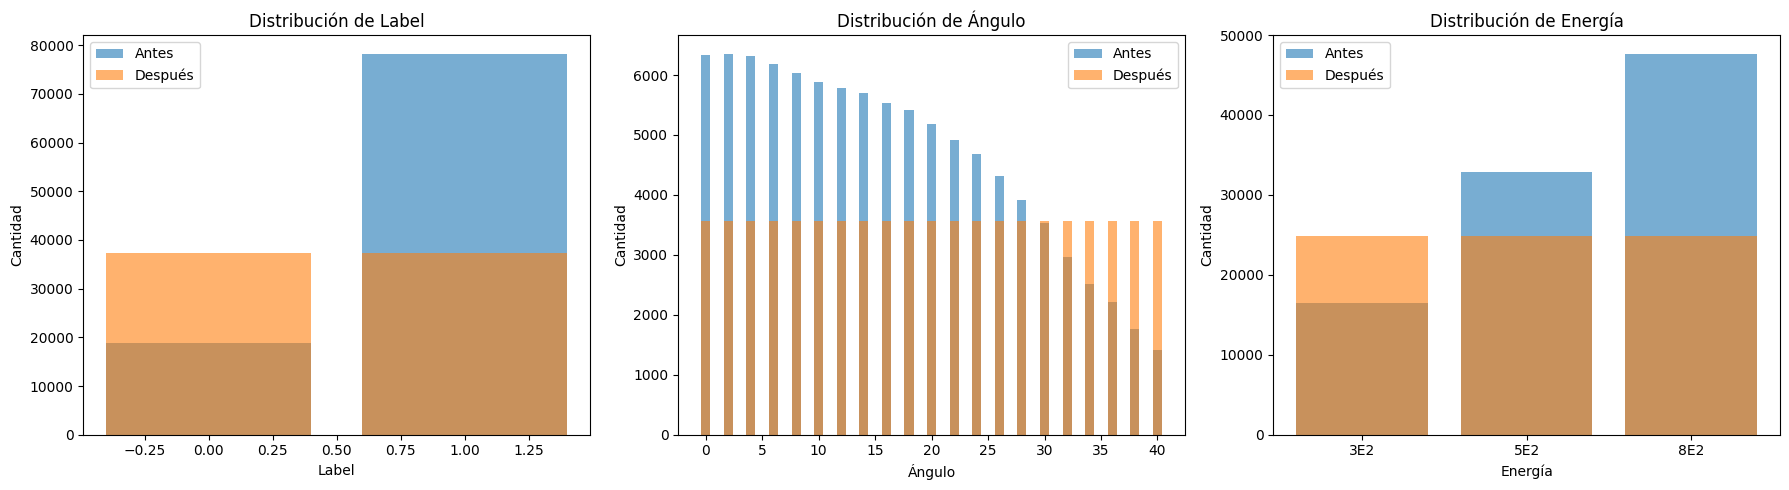

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Antes del balanceo
df_full_counts = {
    "label": df_full["label"].value_counts().sort_index(),
    "angle": df_full["angle"].value_counts().sort_index(),
    "energy": df_full["energy"].value_counts().sort_index(),
}

# Después del balanceo
df_balanced_counts = {
    "label": df_balanced["label"].value_counts().sort_index(),
    "angle": df_balanced["angle"].value_counts().sort_index(),
    "energy": df_balanced["energy"].value_counts().sort_index(),
}

features = ["label", "angle", "energy"]
titles = ["Label", "Ángulo", "Energía"]

for i, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[i]
    ax.bar(df_full_counts[feature].index, df_full_counts[feature].values, alpha=0.6, label="Antes")
    ax.bar(df_balanced_counts[feature].index, df_balanced_counts[feature].values, alpha=0.6, label="Después")
    ax.set_title(f"Distribución de {title}")
    ax.set_xlabel(title)
    ax.set_ylabel("Cantidad")
    ax.legend()

plt.tight_layout()
plt.show()

In [18]:
def resumen_balanceo(df_pre, df_post):
    label_map = {0: "Photon", 1: "Proton"}
    def agregar_tabla(df, nombre):
        tabla = (
            df.assign(label=df["label"].map(label_map))
            .groupby(["energy", "label", "angle"])
            .size()
            .unstack("angle", fill_value=0)
        )
        tabla["Total"] = tabla.sum(axis=1)
        tabla["Set"] = nombre
        return tabla.reset_index()
    tabla_pre = agregar_tabla(df_pre, "Antes")
    tabla_post = agregar_tabla(df_post, "Después")
    tabla_final = pd.concat([tabla_pre, tabla_post], ignore_index=True)
    display(tabla_final)

resumen_balanceo(df_full, df_balanced)


angle,energy,label,0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,...,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0,Total,Set
0,3E2,Photon,179,168,150,154,112,129,130,143,...,78,63,64,38,36,30,31,19,1958,Antes
1,3E2,Proton,1174,1136,1118,1071,1087,1045,979,935,...,513,415,364,287,223,197,124,90,14474,Antes
2,5E2,Photon,449,369,344,371,316,307,261,310,...,233,229,153,161,103,116,101,85,5306,Antes
3,5E2,Proton,1844,1845,1843,1812,1807,1785,1752,1683,...,1226,1075,961,721,634,526,399,287,27611,Antes
4,8E2,Photon,706,847,866,796,713,627,690,651,...,460,394,356,332,242,249,216,214,11496,Antes
5,8E2,Proton,1987,1988,1991,1986,1994,1986,1980,1979,...,1810,1740,1636,1425,1278,1091,895,725,36143,Antes
6,3E2,Photon,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después
7,3E2,Proton,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después
8,5E2,Photon,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después
9,5E2,Proton,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después


energy	Photon	Proton	Total	Set
3E2	14474	1958	16432	Original
5E2	27611	5306	32917	Original
8E2	36143	11496	47639	Original
3E2	12453	12453	24906	Balanced
5E2	12453	12453	24906	Balanced
8E2	12453	12453	24906	Balanced


In [16]:
# ----------------------------- #
# Construcción de secuencias    #
# ----------------------------- #
FEATURE_ORDER = [0, 2, 1, 7, 5, 6]  # detector_id, particle_count, t_bin, total_energy, x_center, y_center
FEATURE_NAMES = ["detector_id", "particle_count", "t_bin", "total_energy", "x_center", "y_center"]

def build_sequence_list(df: pd.DataFrame) -> list[np.ndarray]:
    sequences = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            sequences.append(np.zeros((0, len(FEATURE_ORDER)), dtype=np.float32))
            continue
        order = np.argsort(arr[:, 1])  # t_bin
        ordered = arr[order][:, FEATURE_ORDER].astype(np.float32)
        sequences.append(ordered)
    return sequences

X_sequences = build_sequence_list(df_balanced)
angles = df_balanced["angle"].to_numpy(dtype=np.float32)
labels = df_balanced["label"].to_numpy(dtype=np.int32)
energies = df_balanced["energy"].to_numpy()

In [17]:
# ----------------------------- #
# Features globales             #
# ----------------------------- #
detector_catalog["distance"] = np.hypot(detector_catalog["x_center"], detector_catalog["y_center"])
central_ids = detector_catalog.nsmallest(16, "distance")["detector_id"].astype(int).tolist()

def compute_global_features(sequences: list[np.ndarray], central_detectors: list[int]) -> np.ndarray:
    central_detectors = np.array(central_detectors, dtype=np.int32)
    features = np.zeros((len(sequences), 5), dtype=np.float32)
    for idx, seq in enumerate(sequences):
        if seq.size == 0:
            continue
        det_ids = seq[:, 0].astype(np.int32)
        particle_counts = seq[:, 1]
        t_bins = seq[:, 2]
        tot_energy = seq[:, 3]

        total_particles = float(particle_counts.sum())
        total_energy = float(tot_energy.sum())
        active_detectors = float(np.unique(det_ids).size)
        duration = float(t_bins.max() - t_bins.min())
        mask_central = np.isin(det_ids, central_detectors)
        energy_central = float(tot_energy[mask_central].sum()) if np.any(mask_central) else 0.0

        features[idx] = [
            total_particles,
            total_energy,
            active_detectors,
            duration,
            energy_central,
        ]
    return features

X_global = compute_global_features(X_sequences, central_ids)
X_padded = pad_sequences(X_sequences, padding="post", dtype="float32")
max_sequence_length = int(X_padded.shape[1])

In [18]:
# ----------------------------- #
# Splits estratificados         #
# ----------------------------- #
indices = np.arange(len(X_padded))
strata = np.array([f"{int(round(a))}_{lbl}" for a, lbl in zip(angles, labels)])

train_idx, temp_idx = train_test_split(
    indices,
    test_size=1.0 - TRAIN_RATIO,
    stratify=strata,
    random_state=SEED,
    shuffle=True,
)

val_fraction = VAL_RATIO / (1.0 - TRAIN_RATIO)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=1.0 - val_fraction,
    stratify=strata[temp_idx],
    random_state=SEED,
    shuffle=True,
)

def split_arrays(arr: np.ndarray, tr: np.ndarray, va: np.ndarray, te: np.ndarray):
    return arr[tr], arr[va], arr[te]

X_train, X_val, X_test = split_arrays(X_padded, train_idx, val_idx, test_idx)
Xg_train, Xg_val, Xg_test = split_arrays(X_global, train_idx, val_idx, test_idx)
y_angle_train, y_angle_val, y_angle_test = split_arrays(angles, train_idx, val_idx, test_idx)
y_label_train, y_label_val, y_label_test = split_arrays(labels, train_idx, val_idx, test_idx)
y_energy_train, y_energy_val, y_energy_test = split_arrays(energies, train_idx, val_idx, test_idx)

energy_levels = sorted({e for e in df_balanced["energy"]}, key=lambda x: float(x.replace("E", "e")))
energy_to_idx = {e: idx for idx, e in enumerate(energy_levels)}
y_energy_train_cls = np.array([energy_to_idx[e] for e in y_energy_train], dtype=np.int32)
y_energy_val_cls = np.array([energy_to_idx[e] for e in y_energy_val], dtype=np.int32)
y_energy_test_cls = np.array([energy_to_idx[e] for e in y_energy_test], dtype=np.int32)

def parse_energy(arr: np.ndarray) -> np.ndarray:
    return np.array([float(s.replace("E", "e")) for s in arr], dtype=np.float32)

y_energy_train_cont = parse_energy(y_energy_train)
y_energy_val_cont = parse_energy(y_energy_val)
y_energy_test_cont = parse_energy(y_energy_test)

energy_mean = float(y_energy_train_cont.mean())
energy_std = float(y_energy_train_cont.std(ddof=0) + 1e-8)
y_energy_train_scaled = (y_energy_train_cont - energy_mean) / energy_std
y_energy_val_scaled = (y_energy_val_cont - energy_mean) / energy_std
y_energy_test_scaled = (y_energy_test_cont - energy_mean) / energy_std

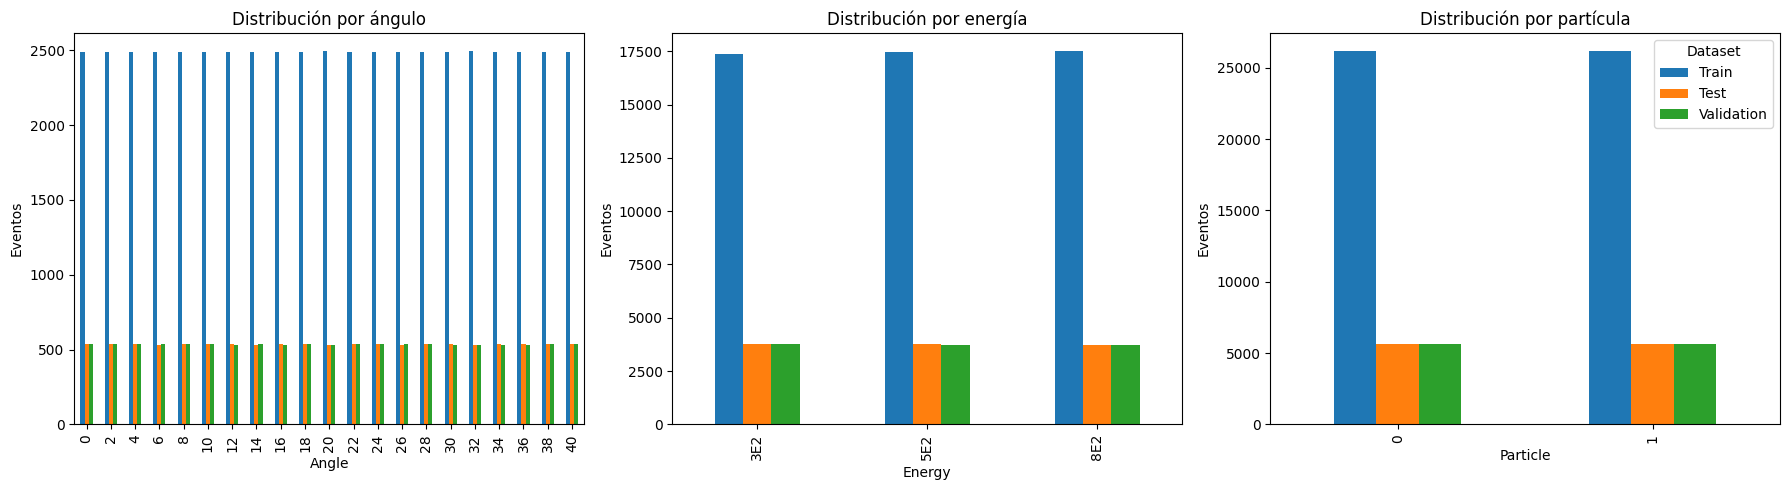

In [19]:
datasets = [
    ("Train", y_angle_train, y_energy_train, y_label_train),
    ("Validation", y_angle_val, y_energy_val, y_label_val),
    ("Test", y_angle_test, y_energy_test, y_label_test),
]

frames = []
for name, angle_arr, energy_arr, particle_arr in datasets:
    frames.append(
        pd.DataFrame(
            {
                "dataset": name,
                "angle": angle_arr.astype(int),
                "energy": energy_arr,
                "particle": particle_arr.astype(int),
            }
        )
    )

dist_df = pd.concat(frames, ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plots = [
    ("angle", "Distribución por ángulo"),
    ("energy", "Distribución por energía"),
    ("particle", "Distribución por partícula"),
]

order = ["Train", "Test", "Validation"]

for i, (ax, (feature, title)) in enumerate(zip(axes, plots)):
    counts = (
        dist_df.groupby(["dataset", feature])
        .size()
        .unstack("dataset", fill_value=0)
        .sort_index()
    )
    counts = counts[order]  # Reordenar columnas
    counts.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Eventos")
    if i == 2:
        ax.legend(title="Dataset")
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

In [20]:
# Crear una lista con los nombres de los sets
sets = ["Train", "Validation", "Test"]

# Crear una lista con las combinaciones energía-tipo
energy_types = []
for energy in energy_levels:
    for label in [0, 1]:
        tipo = "Photon" if label == 0 else "Proton"
        energy_types.append(f"{energy}-{tipo}")

# Inicializar el diccionario de conteos
table_dict = {set_name: [] for set_name in sets}
totals = []

for set_name, angle_arr, energy_arr, label_arr in datasets:
    row = []
    for energy in energy_levels:
        for label in [0, 1]:
            count = ((energy_arr == energy) & (label_arr == label)).sum()
            row.append(count)
    total = sum(row)
    table_dict[set_name] = row + [total]
    totals.append(total)

# Construir el DataFrame
columns = energy_types + ["Total"]
tabla = pd.DataFrame([table_dict[set_name] for set_name in sets], columns=columns, index=sets)
display(tabla)

,3E2-Photon,3E2-Proton,5E2-Photon,5E2-Proton,8E2-Photon,8E2-Proton,Total
Train,8678,8684,8728,8718,8745,8749,52302
Validation,1892,1894,1838,1875,1872,1836,11207
Test,1883,1875,1887,1860,1836,1868,11209


In [ ]:
from tensorflow.keras.metrics import Metric

# ----------------------------- #
# Definición del modelo         #
# ----------------------------- #
def build_multitask_model(sequence_shape: tuple[int, int], global_dim: int) -> Model:
    seq_input = Input(shape=sequence_shape, name="seq_input")
    global_input = Input(shape=(global_dim,), name="global_input")

    x_cnn = layers.Masking(mask_value=0.0, name="masking")(seq_input)
    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_0")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_0")(x_cnn)

    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_1")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_1")(x_cnn)

    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_2")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_2")(x_cnn)
    x_cnn = layers.MaxPooling1D(pool_size=2, padding="same", name="pool_2")(x_cnn)

    x_cnn = layers.Dense(128, activation="elu", name="dense_after_cnn1")(x_cnn)
    x_cnn = layers.Dense(256, activation="elu", name="dense_after_cnn2")(x_cnn)
    x_cnn = layers.Dropout(0.40, name="dropout_after_cnn")(x_cnn)
    x_cnn = layers.Dense(128, activation="elu", name="dense_after_cnn4")(x_cnn)

    def transformer_block(x: tf.Tensor, prefix: str) -> tf.Tensor:
        x_norm = layers.LayerNormalization(name=f"pre_mha_norm_{prefix}")(x)
        mha_layer = layers.MultiHeadAttention(num_heads=1, key_dim=32, name=f"mha_{prefix}")
        attn_output, attn_scores = mha_layer(x_norm, x_norm, return_attention_scores=True)
        layers.Lambda(lambda s: s, name=f"attention_scores_{prefix}")(attn_scores)
        x_add = layers.Add(name=f"add_{prefix}")([x, attn_output])
        x_norm_ffn = layers.LayerNormalization(name=f"pre_ffn_norm_{prefix}")(x_add)
        ffn = layers.Dense(128, activation="elu", name=f"ffn_dense_{prefix}1")(x_norm_ffn)
        ffn = layers.Dense(x.shape[-1], name=f"ffn_dense_{prefix}2")(ffn)
        x_out = layers.Add(name=f"ffn_add_{prefix}")([x_add, ffn])
        return layers.GlobalAveragePooling1D(name=f"temporal_pooling_{prefix}")(x_out)

    feat_angle = transformer_block(x_cnn, "angle")
    feat_particle = transformer_block(x_cnn, "class")
    feat_energy = transformer_block(x_cnn, "energy")

    merged_angle = layers.Concatenate(name="merge_angle")([feat_angle, global_input])
    merged_particle = layers.Concatenate(name="merge_particle")([feat_particle, global_input])
    merged_energy = layers.Concatenate(name="merge_energy")([feat_energy, global_input])

    class_branch = layers.Dropout(0.35, name="dropout_particle")(merged_particle)
    class_branch = layers.Dense(128, activation="elu", name="dense_particle")(class_branch)
    particle_out = layers.Dense(1, activation="sigmoid", dtype="float32", name="particle_output")(class_branch)

    angle_branch = layers.Dense(128, activation="elu", name="dense_angle")(merged_angle)
    angle_out = layers.Dense(1, activation="linear", dtype="float32", name="angle_output")(angle_branch)

    energy_branch = layers.Dense(128, activation="elu", name="dense_energy")(merged_energy)
    energy_branch = layers.Dropout(0.50, name="dropout_energy")(energy_branch)
    energy_out = layers.Dense(1, activation="linear", dtype="float32", name="energy_output")(energy_branch)

    model = Model(inputs=[seq_input, global_input], outputs=[particle_out, angle_out, energy_out], name="CONDOR_Multitask")
    optimizer = optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

    class F1Score(Metric):
        def __init__(self, name="f1_score", threshold=0.5, **kwargs):
            super().__init__(name=name, **kwargs)
            self.threshold = threshold
            self.tp = self.add_weight(name="tp", initializer="zeros")
            self.fp = self.add_weight(name="fp", initializer="zeros")
            self.fn = self.add_weight(name="fn", initializer="zeros")

        def update_state(self, y_true, y_pred, sample_weight=None):
            y_pred = tf.cast(y_pred > self.threshold, tf.float32)
            y_true = tf.cast(y_true, tf.float32)
            tp = tf.reduce_sum(y_true * y_pred)
            fp = tf.reduce_sum((1 - y_true) * y_pred)
            fn = tf.reduce_sum(y_true * (1 - y_pred))
            self.tp.assign_add(tp)
            self.fp.assign_add(fp)
            self.fn.assign_add(fn)

        def result(self):
            precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
            recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
            return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        def reset_state(self):
            self.tp.assign(0)
            self.fp.assign(0)
            self.fn.assign(0)

    model.compile(
        optimizer=optimizer,
        loss={
            "particle_output": "binary_crossentropy",
            "angle_output": tf.keras.losses.Huber(),
            "energy_output": tf.keras.losses.Huber(),
        },
        loss_weights={
            "particle_output": 0.6,
            "angle_output": 1.0,
            "energy_output": 1.5,
        },
        metrics={
            "particle_output": [F1Score(name="f1_score")],
            "angle_output": "mae",
            "energy_output": "mae",
        },
    )
    return model

model = build_multitask_model(sequence_shape=(max_sequence_length, len(FEATURE_NAMES)), global_dim=Xg_train.shape[1])
model.summary()


Model: "CONDOR_Multitask"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 472, 6)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 472, 6)       0           ['seq_input[0][0]']              
                                                                                                  
 conv_0 (Conv1D)                (None, 472, 128)     5504        ['masking[0][0]']                
                                                                                                  
 bn_0 (BatchNormalization)      (None, 472, 128)     512         ['conv_0[0][0]']                 
                                                                                   

In [40]:
# ----------------------------- #
# Entrenamiento                 #
# ----------------------------- #
callbacks_list = [
    callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, verbose=1, min_lr=1e-6),
]

history = model.fit(
    x=[X_train, Xg_train],
    y=[y_label_train, y_angle_train, y_energy_train_scaled],
    validation_data=([X_val, Xg_val], [y_label_val, y_angle_val, y_energy_val_scaled]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/100
1635/1635 [==============================] - 116s 67ms/step - loss: 4.2063 - particle_output_loss: 0.5202 - angle_output_loss: 2.0403 - energy_output_loss: 1.2359 - particle_output_f1_score: 0.7752 - angle_output_mae: 2.4884 - energy_output_mae: 1.6423 - val_loss: 2.0014 - val_particle_output_loss: 0.3647 - val_angle_output_loss: 1.1626 - val_energy_output_loss: 0.4134 - val_particle_output_f1_score: 0.8778 - val_angle_output_mae: 1.5824 - val_energy_output_mae: 0.7905 - lr: 5.0000e-04
Epoch 2/100
1635/1635 [==============================] - 111s 68ms/step - loss: 2.0652 - particle_output_loss: 0.3441 - angle_output_loss: 1.2194 - energy_output_loss: 0.4262 - particle_output_f1_score: 0.8622 - angle_output_mae: 1.6490 - energy_output_mae: 0.8035 - val_loss: 2.0282 - val_particle_output_loss: 0.2244 - val_angle_output_loss: 1.3065 - val_energy_output_loss: 0.3914 - val_particle_output_f1_score: 0.9169 - val_angle_output_mae: 1.7415 - val_energy_output_mae: 0.7675 - lr: 5.000

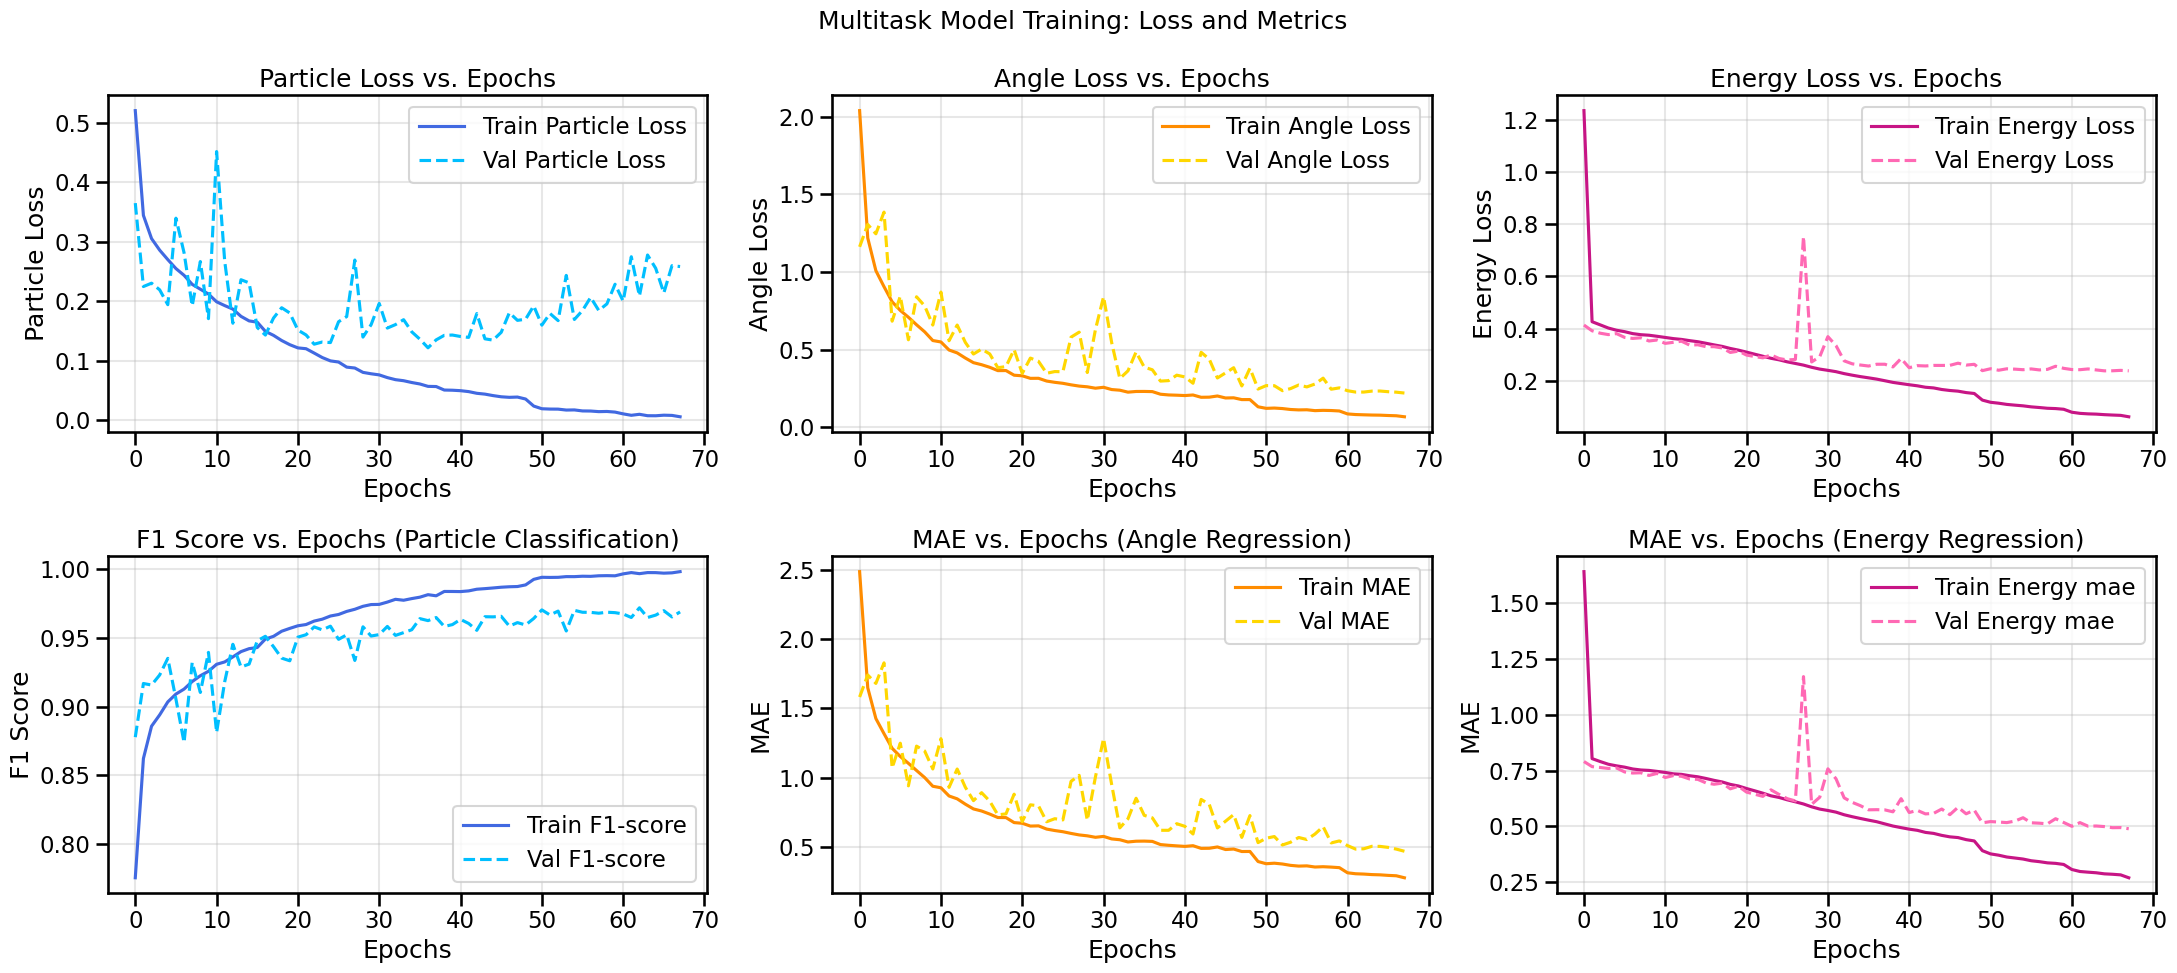

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))

# 1a. Particle Loss
axes[0, 0].plot(history.history['particle_output_loss'], label='Train Particle Loss', color='royalblue')
axes[0, 0].plot(history.history['val_particle_output_loss'], label='Val Particle Loss', color='deepskyblue', linestyle='--')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Particle Loss')
axes[0, 0].set_title('Particle Loss vs. Epochs')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 1b. Angle Loss
axes[0, 1].plot(history.history['angle_output_loss'], label='Train Angle Loss', color='darkorange')
axes[0, 1].plot(history.history['val_angle_output_loss'], label='Val Angle Loss', color='gold', linestyle='--')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Angle Loss')
axes[0, 1].set_title('Angle Loss vs. Epochs')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 1c. Energy Loss
axes[0, 2].plot(history.history['energy_output_loss'], label='Train Energy Loss', color='mediumvioletred')
axes[0, 2].plot(history.history['val_energy_output_loss'], label='Val Energy Loss', color='hotpink', linestyle='--')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Energy Loss')
axes[0, 2].set_title('Energy Loss vs. Epochs')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 2a. Particle Accuracy
axes[1, 0].plot(history.history['particle_output_f1_score'], label='Train F1-score', color='royalblue')
axes[1, 0].plot(history.history['val_particle_output_f1_score'], label='Val F1-score', color='deepskyblue', linestyle='--')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score vs. Epochs (Particle Classification)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 2b. Angle MAE
axes[1, 1].plot(history.history['angle_output_mae'], label='Train MAE', color='darkorange')
axes[1, 1].plot(history.history['val_angle_output_mae'], label='Val MAE', color='gold', linestyle='--')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_title('MAE vs. Epochs (Angle Regression)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 2c. Energy Accuracy
axes[1, 2].plot(history.history['energy_output_mae'], label='Train Energy mae', color='mediumvioletred')
axes[1, 2].plot(history.history['val_energy_output_mae'], label='Val Energy mae', color='hotpink', linestyle='--')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].set_title('MAE vs. Epochs (Energy Regression)')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.suptitle('Multitask Model Training: Loss and Metrics', fontsize=18)
plt.tight_layout()
#plt.savefig(os.path.join(output_dir, "training_multitask_metrics.png"), dpi=200)
plt.show()

In [42]:
# ----------------------------- #
# Evaluación numérica básica    #
# ----------------------------- #
eval_results = model.evaluate(
    x=[X_test, Xg_test],
    y=[y_label_test, y_angle_test, y_energy_test_scaled],
    verbose=1,
)
metrics_names = model.metrics_names
eval_dict = {name: float(value) for name, value in zip(metrics_names, eval_results)}

pred_particle, pred_angle, pred_energy_scaled = model.predict([X_test, Xg_test], batch_size=256, verbose=1)
pred_particle = pred_particle.reshape(-1)
pred_angle = pred_angle.reshape(-1)
pred_energy_scaled = pred_energy_scaled.reshape(-1)
pred_energy_cont = pred_energy_scaled * energy_std + energy_mean

pred_particle_labels = (pred_particle >= 0.5).astype(np.int32)
particle_accuracy = float(np.mean(pred_particle_labels == y_label_test))
angle_mae = float(np.mean(np.abs(pred_angle - y_angle_test)))
energy_mae = float(np.mean(np.abs(pred_energy_cont - y_energy_test_cont)))
energy_rmse = float(np.sqrt(np.mean((pred_energy_cont - y_energy_test_cont) ** 2)))

additional_metrics = {
    "particle_accuracy_custom": particle_accuracy,
    "angle_mae_deg_custom": angle_mae,
    "energy_mae_GeV_custom": energy_mae,
    "energy_rmse_GeV_custom": energy_rmse,
}

44/44 [==============================] - 5s 83ms/step


In [43]:
# ----------------------------- #
# Persistencia de artefactos    #
# ----------------------------- #
MODEL_DIR = ARTIFACTS_DIR / "model"
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "condor_multitask_model.keras"
model.save(model_path)
print(f"Modelo guardado en: {model_path}")

history_df = pd.DataFrame(history.history)
history_csv = MODEL_DIR / "training_history.csv"
history_df.to_csv(history_csv, index=False)
print(f"Historial de entrenamiento guardado en: {history_csv}")

metrics_path = MODEL_DIR / "evaluation_metrics.json"
with metrics_path.open("w", encoding="utf-8") as fh:
    json.dump(
        {"keras_metrics": eval_dict, "custom_metrics": additional_metrics},
        fh,
        indent=2,
    )
print(f"Métricas básicas guardadas en: {metrics_path}")

pred_npz_path = ARTIFACTS_DIR / "test_predictions.npz"
np.savez_compressed(
    pred_npz_path,
    particle_probability=pred_particle.astype(np.float32),
    particle_label_pred=pred_particle_labels,
    particle_label_true=y_label_test,
    angle_pred=pred_angle.astype(np.float32),
    angle_true=y_angle_test,
    energy_pred_scaled=pred_energy_scaled.astype(np.float32),
    energy_pred=pred_energy_cont.astype(np.float32),
    energy_true=y_energy_test_cont,
    energy_true_str=np.array(y_energy_test, dtype="<U8"),
    energy_levels=np.array(energy_levels, dtype="<U8"),
    energy_mean=np.array([energy_mean], dtype=np.float32),
    energy_std=np.array([energy_std], dtype=np.float32),
)
print(f"Predicciones de test guardadas en: {pred_npz_path}")

Modelo guardado en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\model\condor_multitask_model.keras
Historial de entrenamiento guardado en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\model\training_history.csv
Métricas básicas guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\model\evaluation_metrics.json
Predicciones de test guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\test_predictions.npz


In [44]:
metadata = {
    "seed": SEED,
    "energies_used": list(ENERGY_FILTER),
    "angle_max_deg": ANGLE_MAX,
    "min_total_particles": MIN_TOTAL_PARTICLES,
    "balance_target_per_group": target_per_group,
    "num_events_total": int(len(df_balanced)),
    "train_val_test_split": {
        "train": int(len(train_idx)),
        "val": int(len(val_idx)),
        "test": int(len(test_idx)),
    },
    "feature_order": FEATURE_NAMES,
    "max_sequence_length": max_sequence_length,
    "global_features_definition": [
        "sum_particle_count",
        "sum_total_energy",
        "num_active_detectors",
        "duration_tbin",
        "sum_total_energy_central_ids",
    ],
    "central_detector_ids": [int(x) for x in central_ids],
    "energy_scaling": {"mean": energy_mean, "std": energy_std},
    "artifacts": {
        "dataset_npz": str(pred_npz_path),
        "history_csv": str(history_csv),
        "model_path": str(model_path),
        "metrics_path": str(metrics_path),
        "predictions_npz": str(pred_npz_path),
        "detector_catalog_csv": str(ARTIFACTS_DIR / "detector_catalog.csv"),
    },
    "keras_metrics": eval_dict,
    "custom_metrics": additional_metrics,
}

metadata_path = ARTIFACTS_DIR / "preprocessing_metadata.json"
with metadata_path.open("w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)
print(f"Metadata guardada en: {metadata_path}")

Metadata guardada en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\preprocessing_metadata.json


In [45]:
# ----------------------------- #
# Visualización de predicciones #
# ----------------------------- #
sns.set_context("talk")
plots_dir = ARTIFACTS_DIR / "diagnostics"
plots_dir.mkdir(parents=True, exist_ok=True)

pred_summary = pd.DataFrame(
    {
        "particle_true": y_label_test.astype(int),
        "particle_pred_prob": pred_particle.astype(float),
        "particle_pred_label": pred_particle_labels.astype(int),
        "angle_true_deg": y_angle_test.astype(float),
        "angle_pred_deg": pred_angle.astype(float),
        "energy_true_GeV": y_energy_test_cont.astype(float),
        "energy_pred_GeV": pred_energy_cont.astype(float),
        "energy_level_true": y_energy_test,
    }
)
pred_summary["angle_error_deg"] = pred_summary["angle_pred_deg"] - pred_summary["angle_true_deg"]
pred_summary["energy_error_GeV"] = pred_summary["energy_pred_GeV"] - pred_summary["energy_true_GeV"]
pred_summary["particle_correct"] = pred_summary["particle_pred_label"] == pred_summary["particle_true"]
pred_summary["angle_abs_error_deg"] = pred_summary["angle_error_deg"].abs()
pred_summary["energy_abs_error_GeV"] = pred_summary["energy_error_GeV"].abs()

angle_metrics = {
    "MAE (deg)": mean_absolute_error(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
    "RMSE (deg)": mean_squared_error(
        pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"], squared=False
    ),
    "R2": r2_score(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
}
energy_metrics = {
    "MAE (GeV)": mean_absolute_error(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
    "RMSE (GeV)": mean_squared_error(
        pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"], squared=False
    ),
    "R2": r2_score(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
}

display(pd.DataFrame(angle_metrics, index=["Ángulo"]).T.round(4))
display(pd.DataFrame(energy_metrics, index=["Energía"]).T.round(4))

c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Ángulo
MAE (deg),0.5052
RMSE (deg),0.7536
R2,0.9961


,Energía
MAE (GeV),103.2519
RMSE (GeV),150.2726
R2,0.4639


,precision,recall,f1-score,support
Proton,0.9675,0.9720,0.9697,5606.0000
Photon,0.9718,0.9673,0.9696,5603.0000
accuracy,0.9697,0.9697,0.9697,0.9697
macro avg,0.9697,0.9697,0.9697,11209.0000
weighted avg,0.9697,0.9697,0.9697,11209.0000


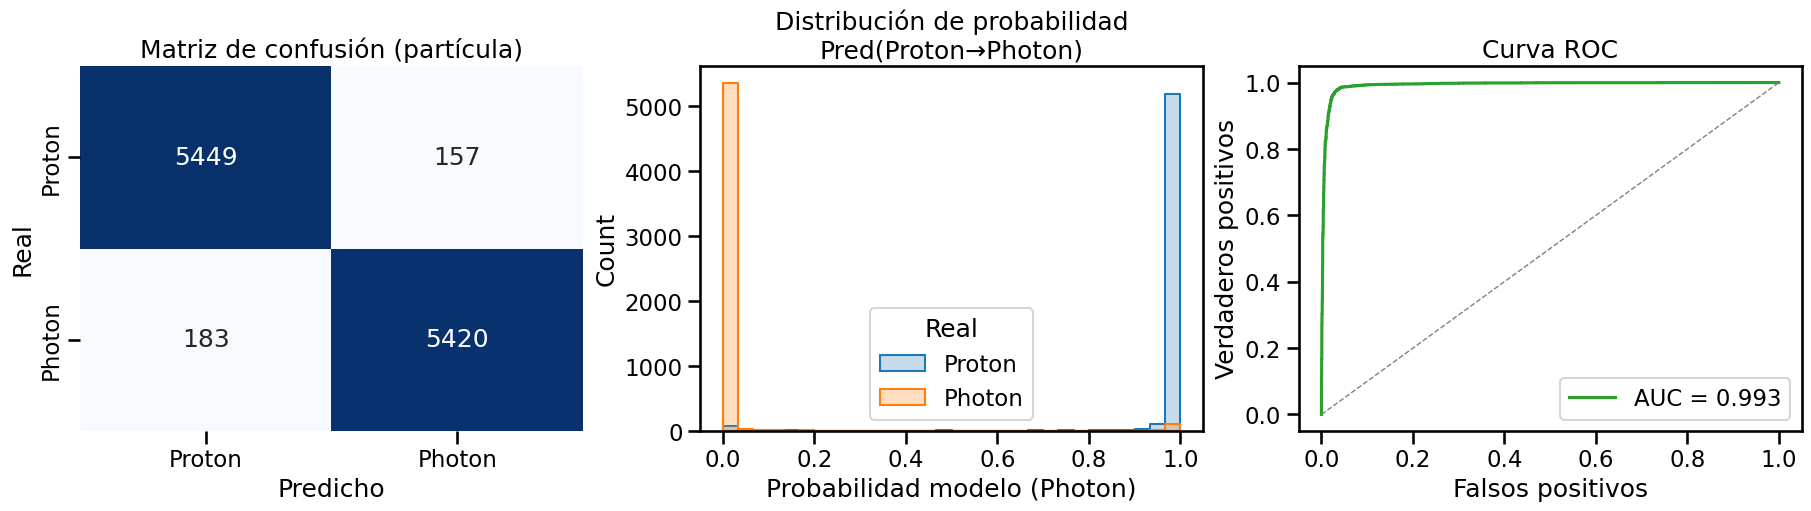

In [46]:
# ----------------------------- #
# Diagnóstico de clasificación de partícula #
# ----------------------------- #
cm_particle = confusion_matrix(pred_summary["particle_true"], pred_summary["particle_pred_label"])
particle_report = classification_report(
    pred_summary["particle_true"],
    pred_summary["particle_pred_label"],
    target_names=["Proton", "Photon"],
    output_dict=True,
)
display(pd.DataFrame(particle_report).T.round(4))

fpr, tpr, _ = roc_curve(pred_summary["particle_true"], pred_summary["particle_pred_prob"])
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

sns.heatmap(cm_particle, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de confusión (partícula)")
axes[0].set_xticklabels(["Proton", "Photon"])
axes[0].set_yticklabels(["Proton", "Photon"])

sns.histplot(
    data=pred_summary,
    x="particle_pred_prob",
    hue="particle_true",
    bins=30,
    element="step",
    common_norm=False,
    palette={0: "tab:orange", 1: "tab:blue"},
    ax=axes[1],
)
axes[1].set_title("Distribución de probabilidad\nPred(Proton→Photon)")
axes[1].set_xlabel("Probabilidad modelo (Photon)")
axes[1].legend(title="Real", labels=["Proton", "Photon"])

axes[2].plot(fpr, tpr, color="tab:green", label=f"AUC = {roc_auc:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
axes[2].set_xlabel("Falsos positivos")
axes[2].set_ylabel("Verdaderos positivos")
axes[2].set_title("Curva ROC")
axes[2].legend(loc="lower right")

fig.savefig(plots_dir / "particle_predictions_overview.png", dpi=200)
plt.show()

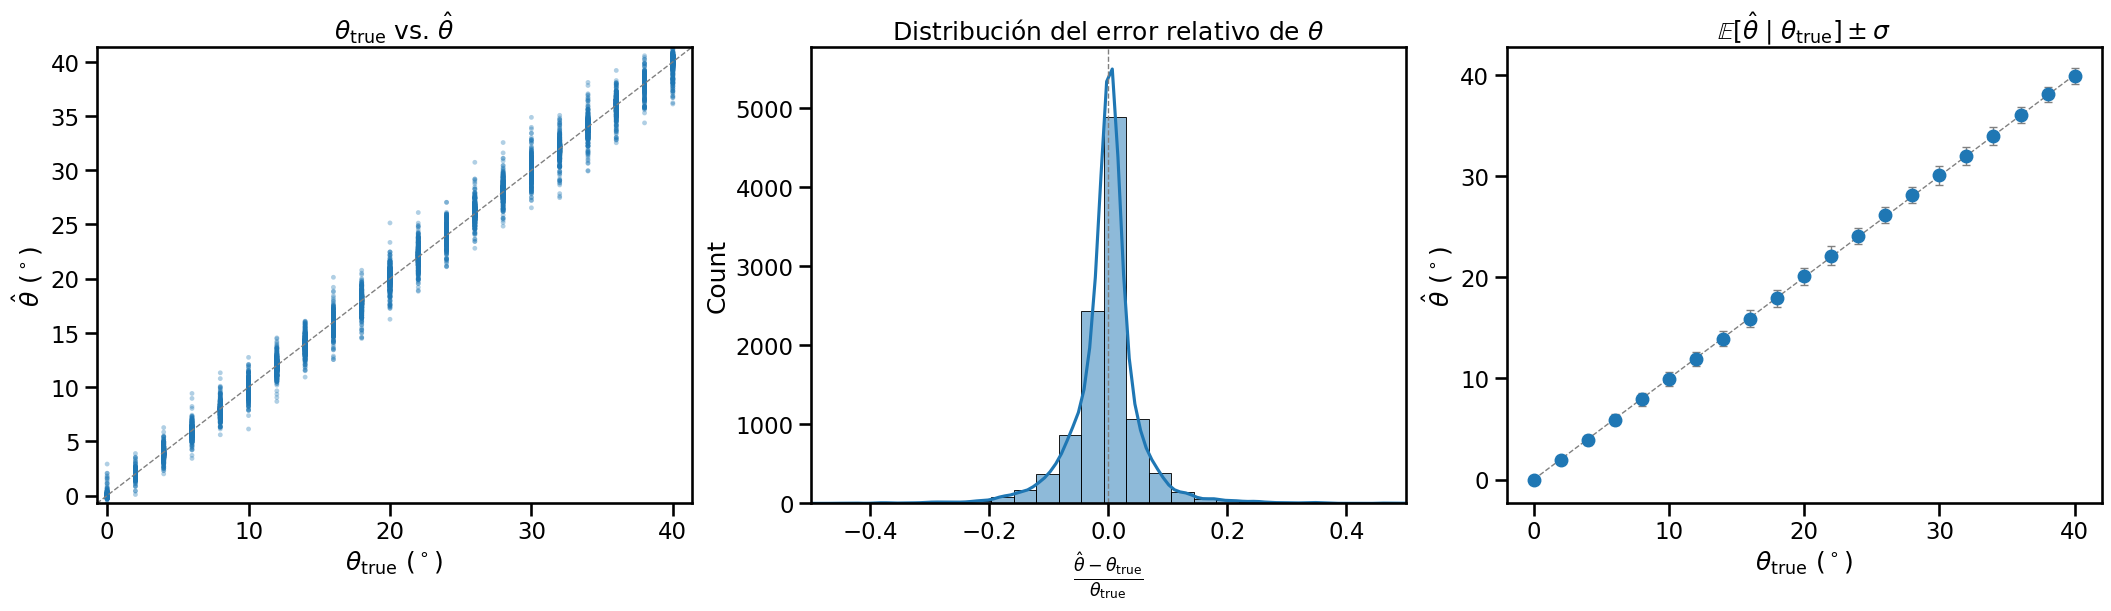

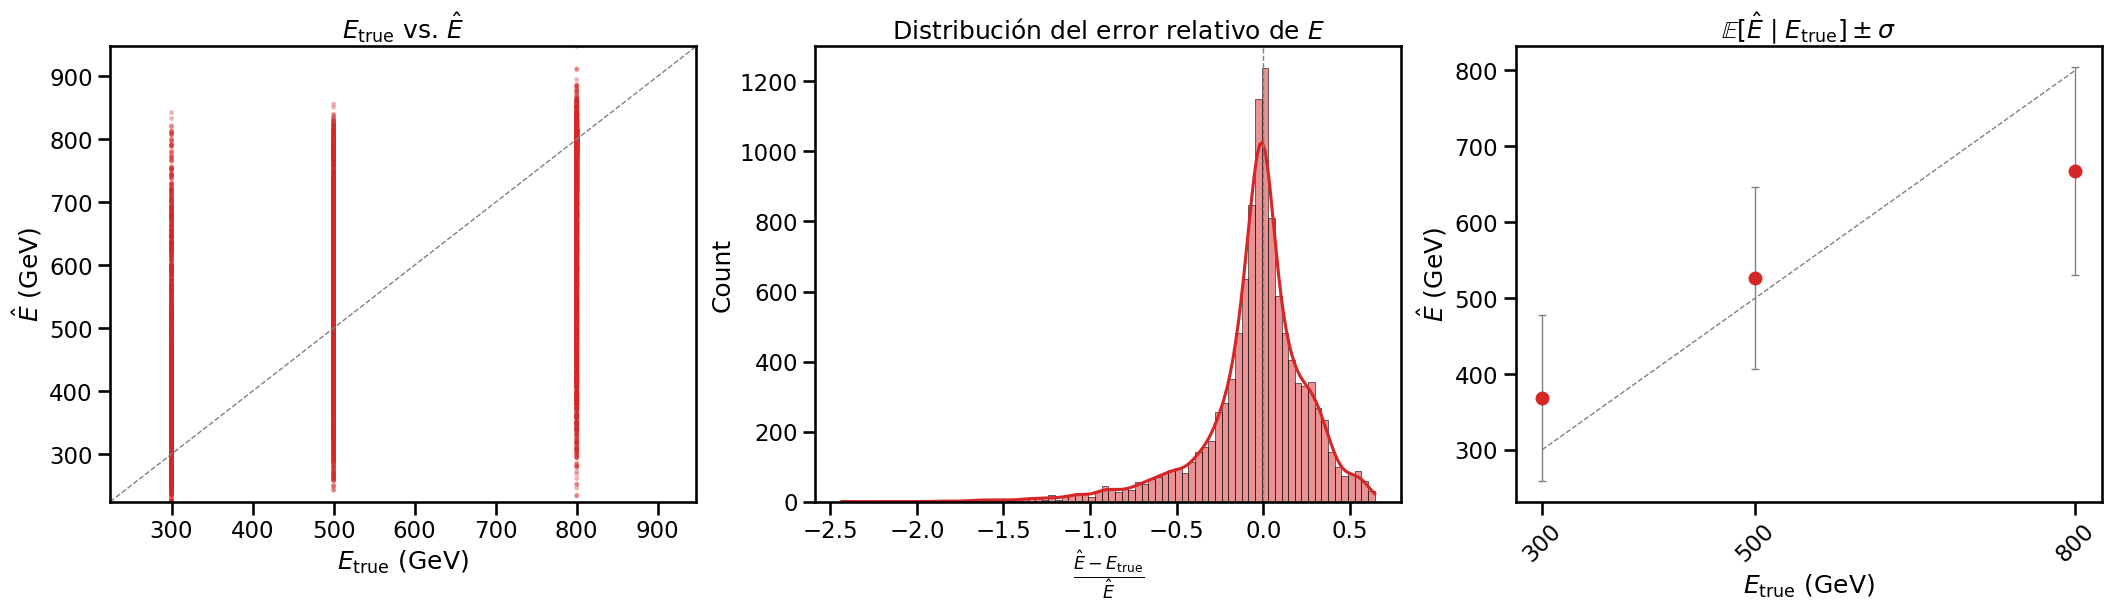

Gráficas de desempeño guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\diagnostics


In [47]:
# ----------------------------- #
# Diagnóstico de ángulo y energía #
# ----------------------------- #
theta_hat = pred_summary["angle_pred_deg"]
theta_true = pred_summary["angle_true_deg"]

denom = theta_true.replace(0.0, np.nan)
theta_rel_error = (theta_hat - theta_true) / denom
theta_rel_error = theta_rel_error.replace([np.inf, -np.inf], np.nan)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

axes[0].scatter(
    theta_true,
    theta_hat,
    s=12,
    alpha=0.35,
    color="tab:blue",
    edgecolors="none",
)
lims_angle = [
    pred_summary[["angle_true_deg", "angle_pred_deg"]].min().min(),
    pred_summary[["angle_true_deg", "angle_pred_deg"]].max().max(),
]
axes[0].plot(lims_angle, lims_angle, color="gray", linestyle="--", linewidth=1)
axes[0].set_xlim(lims_angle)
axes[0].set_ylim(lims_angle)
axes[0].set_xlabel(r"$\theta_{\mathrm{true}}\ (^\circ)$")
axes[0].set_ylabel(r"$\hat{\theta}\ (^\circ)$")
axes[0].set_title(r"$\theta_{\mathrm{true}}$ vs. $\hat{\theta}$")

sns.histplot(
    theta_rel_error.dropna(),
    bins=50,
    kde=True,
    color="tab:blue",
    ax=axes[1],
)
axes[1].axvline(0.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\frac{\hat{\theta}-\theta_{\mathrm{true}}}{\theta_{\mathrm{true}}}$")
axes[1].set_title(r"Distribución del error relativo de $\theta$")
axes[1].set_xlim(-0.5, 0.5)

angle_group = (
    pred_summary.assign(angle_bin=np.round(theta_true, 1))
    .groupby("angle_bin")
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)
axes[2].errorbar(
    angle_group["angle_bin"],
    angle_group["mean_pred"],
    yerr=angle_group["std_pred"].fillna(0.0),
    fmt="o",
    color="tab:blue",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
)
axes[2].plot(
    angle_group["angle_bin"],
    angle_group["angle_bin"],
    color="gray",
    linestyle="--",
    linewidth=1,
)
axes[2].set_xlabel(r"$\theta_{\mathrm{true}}\ (^\circ)$")
axes[2].set_ylabel(r"$\hat{\theta}\ (^\circ)$")
axes[2].set_title(r"$\mathbb{E}[\hat{\theta}\mid\theta_{\mathrm{true}}] \pm \sigma$")

fig.savefig(plots_dir / "angle_predictions_overview.png", dpi=200)
plt.show()

E_hat = pred_summary["energy_pred_GeV"]
E_true = pred_summary["energy_true_GeV"]
E_rel_error = (E_hat - E_true) / E_hat.replace(0, np.nan)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

axes[0].scatter(
    E_true,
    E_hat,
    s=12,
    alpha=0.35,
    color="tab:red",
    edgecolors="none",
)
lims_energy = [
    pred_summary[["energy_true_GeV", "energy_pred_GeV"]].min().min(),
    pred_summary[["energy_true_GeV", "energy_pred_GeV"]].max().max(),
]
axes[0].plot(lims_energy, lims_energy, color="gray", linestyle="--", linewidth=1)
axes[0].set_xlim(lims_energy)
axes[0].set_ylim(lims_energy)
axes[0].set_xlabel(r"$E_{\mathrm{true}}\ (\mathrm{GeV})$")
axes[0].set_ylabel(r"$\hat{E}\ (\mathrm{GeV})$")
axes[0].set_title(r"$E_{\mathrm{true}}$ vs. $\hat{E}$")

sns.histplot(
    E_rel_error,
    bins=80,
    kde=True,
    color="tab:red",
    ax=axes[1],
)
axes[1].axvline(0.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\frac{\hat{E}-E_{\mathrm{true}}}{\hat{E}}$")
axes[1].set_title(r"Distribución del error relativo de $E$")

energy_group = (
    pred_summary.groupby("energy_level_true")
    .agg(
        mean_pred=("energy_pred_GeV", "mean"),
        std_pred=("energy_pred_GeV", "std"),
        true_energy=("energy_true_GeV", "mean"),
    )
    .reset_index()
    .sort_values("true_energy")
)
axes[2].errorbar(
    energy_group["true_energy"],
    energy_group["mean_pred"],
    yerr=energy_group["std_pred"].fillna(0.0),
    fmt="o",
    color="tab:red",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
)
axes[2].plot(
    energy_group["true_energy"],
    energy_group["true_energy"],
    color="gray",
    linestyle="--",
    linewidth=1,
)
axes[2].set_xlabel(r"$E_{\mathrm{true}}\ (\mathrm{GeV})$")
axes[2].set_ylabel(r"$\hat{E}\ (\mathrm{GeV})$")
axes[2].set_title(r"$\mathbb{E}[\hat{E}\mid E_{\mathrm{true}}] \pm \sigma$")
axes[2].set_xticks(energy_group["true_energy"])
axes[2].tick_params(axis="x", rotation=45)

fig.savefig(plots_dir / "energy_predictions_overview.png", dpi=200)
plt.show()

print(f"Gráficas de desempeño guardadas en: {plots_dir}")

Capas con atención disponibles: ['angle', 'energy', 'particle']


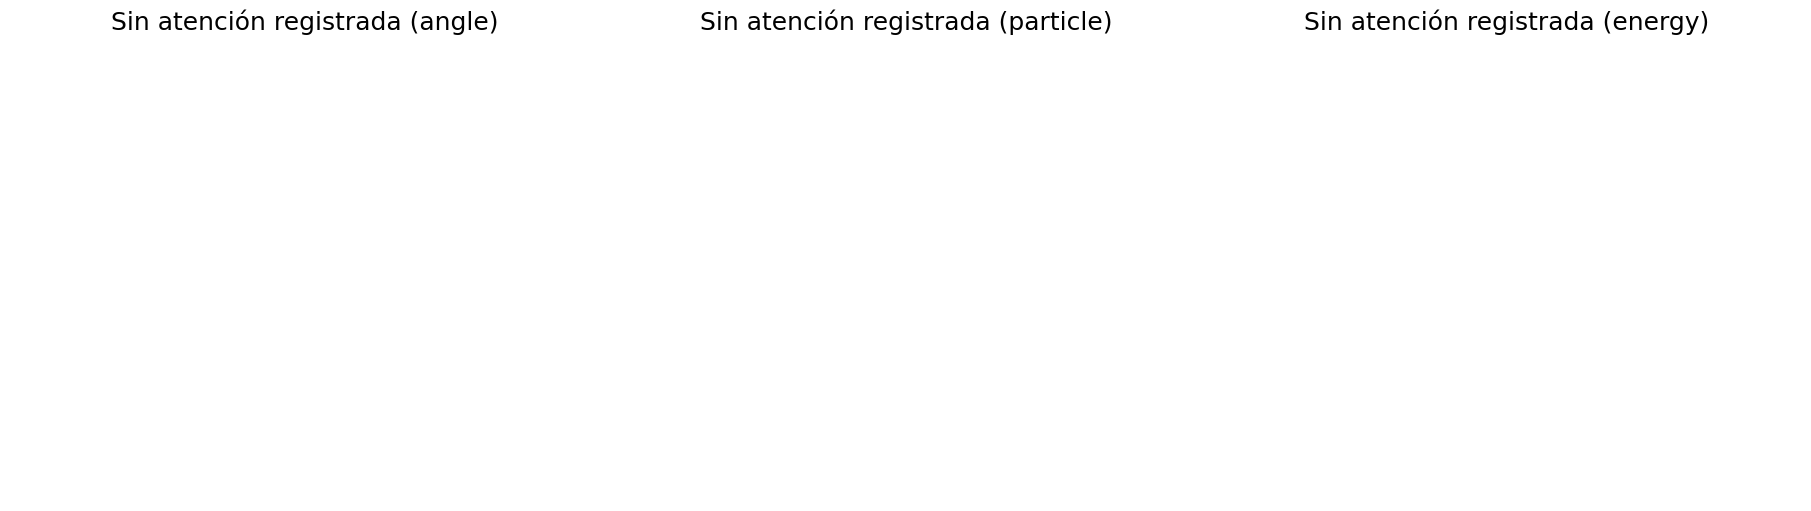

In [30]:
# ----------------------------- #
# Herramientas para visualizar atención (secuencia cruda) #
# ----------------------------- #
RAW_ATTENTION_KEYS = {
    "angle": "angle_raw",
    "particle": "particle_raw",
    "energy": "energy_raw",
}

_ATTENTION_FETCHER = None
_ATTENTION_LOGICAL_ORDER: list[str] = []

def _ensure_attention_fetcher() -> Optional[Model]:
    global _ATTENTION_FETCHER, _ATTENTION_LOGICAL_ORDER
    if _ATTENTION_FETCHER is not None:
        return _ATTENTION_FETCHER

    outputs = []
    logical_order = []
    for logical_name, layer_name in RAW_ATTENTION_KEYS.items():
        recorder = model.attention_recorders.get(layer_name)
        if recorder is None:
            continue
        outputs.append(recorder.output)
        logical_order.append(logical_name)

    if outputs:
        _ATTENTION_FETCHER = Model(model.inputs, outputs, name="attention_fetcher")
        _ATTENTION_LOGICAL_ORDER = logical_order
    else:
        _ATTENTION_LOGICAL_ORDER = []

    return _ATTENTION_FETCHER


def _forward_with_attention(indices):
    seq_batch = X_test[indices]
    glob_batch = Xg_test[indices]
    outputs = {key: None for key in RAW_ATTENTION_KEYS}

    if len(indices) == 0:
        return outputs

    fetcher = _ensure_attention_fetcher()
    if fetcher is None:
        return outputs

    attn_values = fetcher.predict([seq_batch, glob_batch], verbose=0)
    if len(_ATTENTION_LOGICAL_ORDER) == 1:
        attn_values = [attn_values]

    for logical_name, tensor in zip(_ATTENTION_LOGICAL_ORDER, attn_values):
        outputs[logical_name] = np.asarray(tensor)

    return outputs


def _valid_lengths(seq_batch):
    mask = ~np.all(np.isclose(seq_batch, 0.0, atol=1e-8), axis=-1)
    return mask.sum(axis=1).astype(int)


def plot_raw_attention_for_sample(sample_idx: int):
    """Mapa de atención cruda para una muestra individual."""
    attn_batches = _forward_with_attention([sample_idx])
    seq_sample = X_test[sample_idx]
    valid_len = int(_valid_lengths(seq_sample[None, ...])[0])
    if valid_len == 0:
        raise ValueError(f"La muestra {sample_idx} no contiene tokens válidos.")

    fig, axes = plt.subplots(1, len(RAW_ATTENTION_KEYS), figsize=(6 * len(RAW_ATTENTION_KEYS), 5), constrained_layout=True)
    axes = np.atleast_1d(axes)

    task_titles = {
        "particle": "Partícula",
        "angle": f"Ángulo (real {pred_summary.iloc[sample_idx]['angle_true_deg']:.1f}°)",
        "energy": f"Energía (real {pred_summary.iloc[sample_idx]['energy_true_GeV']:.1f} GeV)",
    }

    for ax, (logical_name, layer_name) in zip(axes, RAW_ATTENTION_KEYS.items()):
        attn_tensor = attn_batches[logical_name]
        if attn_tensor is None:
            ax.axis("off")
            ax.set_title(f"Sin atención registrada ({logical_name})")
            continue
        mat = attn_tensor[0]
        if mat.ndim == 3:
            mat = mat.mean(axis=0)
        mat = mat[:valid_len, :valid_len]
        sns.heatmap(mat, cmap="viridis", square=True, ax=ax)
        ax.set_xlabel("Key (paso temporal)")
        ax.set_ylabel("Query (paso temporal)")
        ax.set_title(f"Atención {task_titles.get(logical_name, logical_name.title())}\nidx = {sample_idx}")

    plt.show()


print("Capas con atención disponibles:", sorted(model.attention_recorders.keys()))
plot_raw_attention_for_sample(sample_idx=0)

In [ ]:
def summarize_raw_attention(indices, task: str, batch_size: int = 64):
    """Promedia la atención cruda para un subconjunto de índices."""
    layer_name = RAW_ATTENTION_KEYS[task]
    max_len = X_test.shape[1]
    sum_mat = np.zeros((max_len, max_len), dtype=np.float64)
    count_mat = np.zeros((max_len, max_len), dtype=np.int32)
    key_sum = np.zeros(max_len, dtype=np.float64)
    key_count = np.zeros(max_len, dtype=np.int32)
    query_sum = np.zeros(max_len, dtype=np.float64)
    query_count = np.zeros(max_len, dtype=np.int32)

    for start in range(0, len(indices), batch_size):
        batch_indices = indices[start:start + batch_size]
        if len(batch_indices) == 0:
            continue
        attn_batches = _forward_with_attention(batch_indices)
        attn_tensor = attn_batches[task]
        if attn_tensor is None:
            continue
        if attn_tensor.ndim == 4:
            attn_tensor = attn_tensor.mean(axis=1)
        seq_batch = X_test[batch_indices]
        valid_lengths = _valid_lengths(seq_batch)
        for b_idx, L_valid in enumerate(valid_lengths):
            if L_valid == 0:
                continue
            mat = attn_tensor[b_idx, :L_valid, :L_valid]
            sum_mat[:L_valid, :L_valid] += mat
            count_mat[:L_valid, :L_valid] += 1
            col = mat.sum(axis=0)
            row = mat.sum(axis=1)
            key_sum[:L_valid] += col
            key_count[:L_valid] += 1
            query_sum[:L_valid] += row
            query_count[:L_valid] += 1

    avg_mat = np.divide(sum_mat, np.where(count_mat == 0, 1, count_mat), where=count_mat > 0)
    avg_mat[count_mat == 0] = np.nan
    avg_keys = np.divide(key_sum, np.where(key_count == 0, 1, key_count), where=key_count > 0)
    avg_keys[key_count == 0] = np.nan
    avg_queries = np.divide(query_sum, np.where(query_count == 0, 1, query_count), where=query_count > 0)
    avg_queries[query_count == 0] = np.nan

    valid_positions = np.where(key_count > 0)[0]
    eff_len = int(valid_positions[-1] + 1) if valid_positions.size else 0

    return {
        "avg_matrix": avg_mat,
        "avg_keys": avg_keys,
        "avg_queries": avg_queries,
        "effective_length": eff_len,
    }



def plot_attention_grid(
    summary_by_task: Dict[str, Dict[str, Any]],
    title: Optional[str] = None,
    save_path: Optional[Path] = None,
):
    tasks = list(summary_by_task.keys())
    if not tasks:
        print("No hay resúmenes de atención para mostrar.")
        return

    valid_blocks = []
    for task in tasks:
        eff = summary_by_task[task]["effective_length"]
        if eff > 0:
            data = summary_by_task[task]["avg_matrix"][:eff, :eff]
            valid_blocks.append(data[~np.isnan(data)])
    if valid_blocks:
        vmax = np.nanpercentile(np.concatenate(valid_blocks), 99)
        if not np.isfinite(vmax) or vmax <= 0:
            vmax = 1.0
    else:
        vmax = 1.0

    fig, axes = plt.subplots(3, len(tasks), figsize=(5.5 * len(tasks), 12), constrained_layout=True)
    if len(tasks) == 1:
        axes = np.reshape(axes, (3, 1))
    heatmap_mappable = None

    for col, task in enumerate(tasks):
        summary = summary_by_task[task]
        eff_len = summary["effective_length"]
        ax_heat = axes[0, col]
        ax_keys = axes[1, col]
        ax_queries = axes[2, col]

        if eff_len == 0:
            ax_heat.axis("off")
            ax_keys.axis("off")
            ax_queries.axis("off")
            ax_heat.set_title(f"{task} sin tokens válidos")
            continue

        data = summary["avg_matrix"][:eff_len, :eff_len]
        mask = np.isnan(data)
        hm = sns.heatmap(
            data,
            cmap="mako",
            vmin=0.0,
            vmax=vmax,
            mask=mask,
            cbar=False,
            ax=ax_heat,
        )
        if heatmap_mappable is None:
            heatmap_mappable = hm.collections[0]
        ax_heat.set_title(f"{task.title()} – atención media")
        ax_heat.set_ylabel("Query (paso)" if col == 0 else "")
        ax_heat.set_xlabel("Key (paso)")

        indices = np.arange(eff_len)
        ax_keys.bar(indices, summary["avg_keys"][:eff_len], color="tab:purple")
        ax_keys.set_title("Importancia media (Key)")
        ax_keys.set_ylabel("Peso" if col == 0 else "")
        ax_keys.set_xlabel("Paso de la secuencia")

        ax_queries.bar(indices, summary["avg_queries"][:eff_len], color="tab:olive")
        ax_queries.set_title("Importancia media (Query)")
        ax_queries.set_ylabel("Peso" if col == 0 else "")
        ax_queries.set_xlabel("Paso de la secuencia")

    if heatmap_mappable is not None:
        cbar = fig.colorbar(heatmap_mappable, ax=axes[0, :].ravel().tolist(), fraction=0.025, pad=0.02)
        cbar.set_label("Peso de atención")

    if title:
        fig.suptitle(title, fontsize=18)
    if save_path is not None:
        fig.savefig(save_path, dpi=200)
    plt.show()

In [ ]:
# ----------------------------- #
# Atención agregada (promedio y por desempeño) #
# ----------------------------- #
indices_all = np.arange(len(X_test))
attention_all = {task: summarize_raw_attention(indices_all, task) for task in RAW_ATTENTION_KEYS}
plot_attention_grid(
    attention_all,
    title="Atención promedio sobre secuencia cruda",
    save_path=plots_dir / "attention_raw_summary.png",
)

particle_correct_idx = pred_summary.index[pred_summary["particle_correct"]].to_numpy()
particle_wrong_idx = pred_summary.index[~pred_summary["particle_correct"]].to_numpy()

angle_thresh = 4.0 
angle_ok_idx = pred_summary.index[pred_summary["angle_abs_error_deg"] <= angle_thresh].to_numpy()
angle_bad_idx = pred_summary.index[pred_summary["angle_abs_error_deg"] > angle_thresh].to_numpy()

energy_thresh = 200.0
energy_ok_idx = pred_summary.index[pred_summary["energy_abs_error_GeV"] <= energy_thresh].to_numpy()
energy_bad_idx = pred_summary.index[pred_summary["energy_abs_error_GeV"] > energy_thresh].to_numpy()

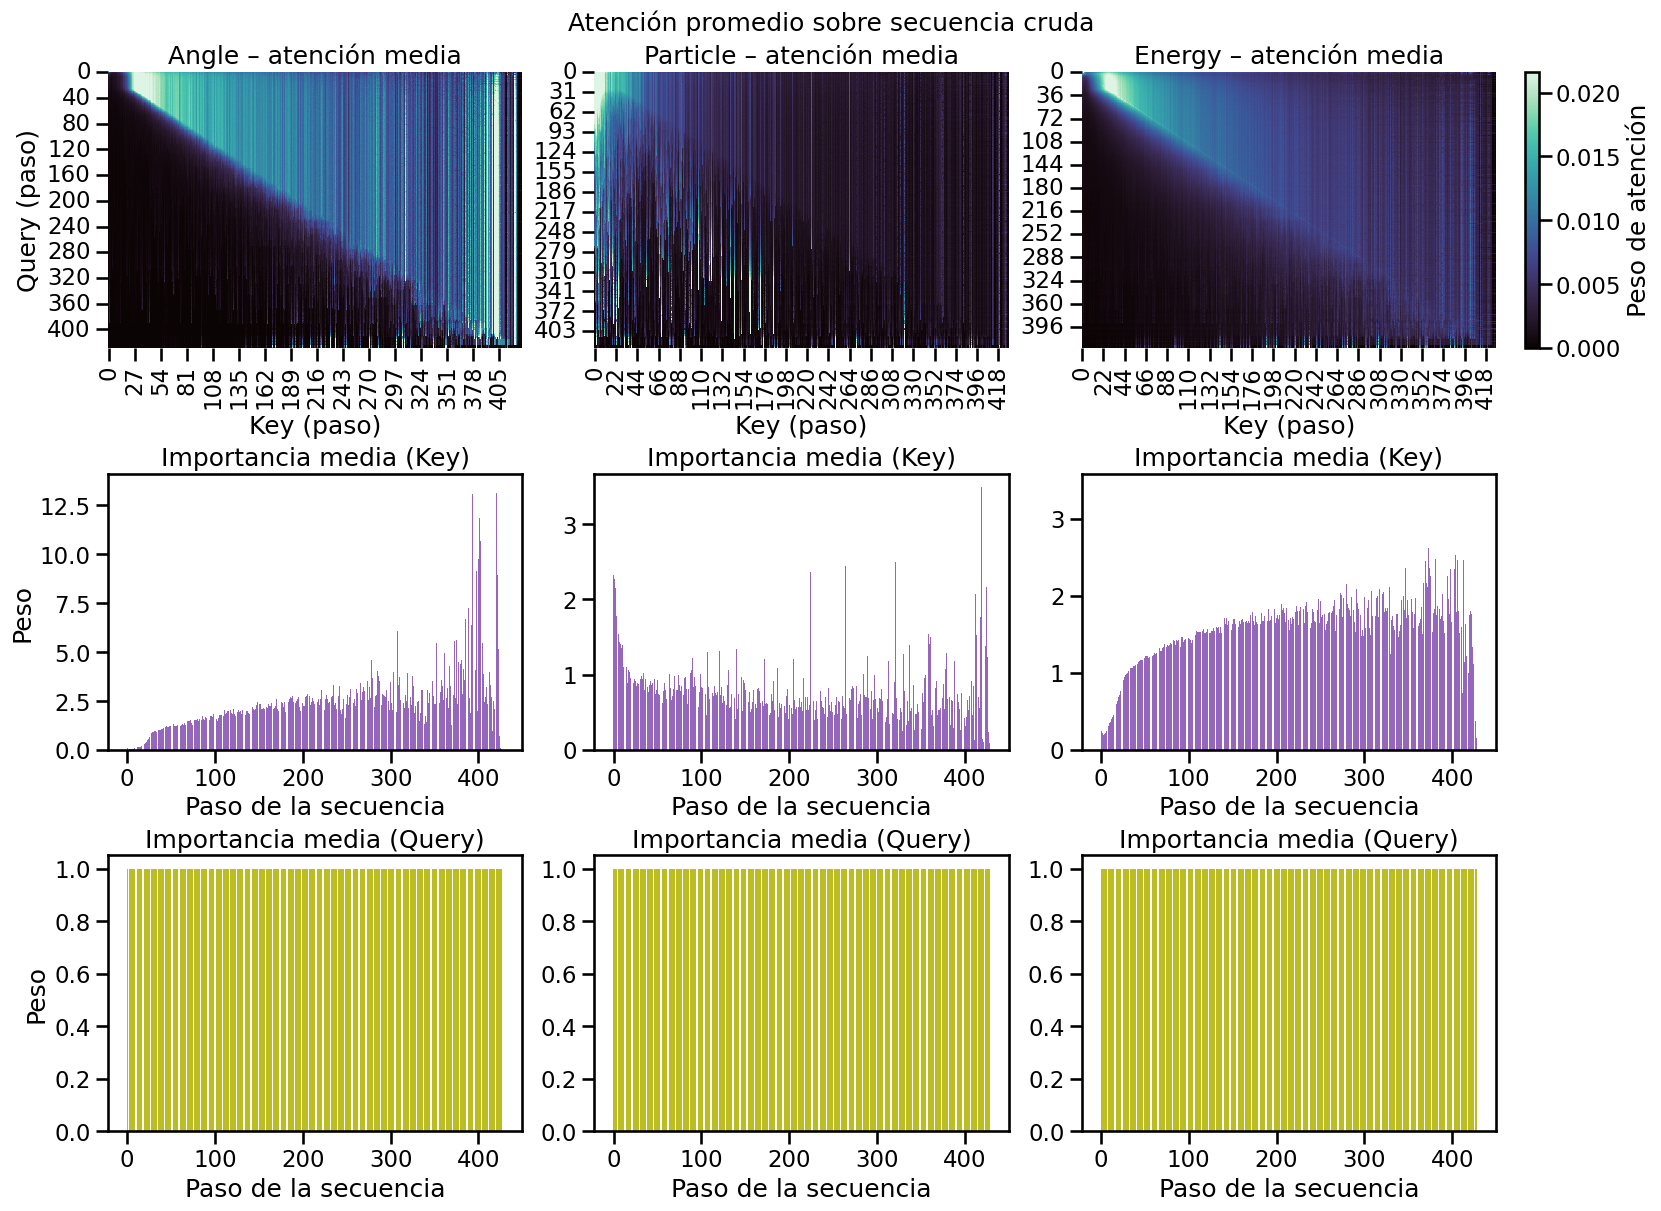

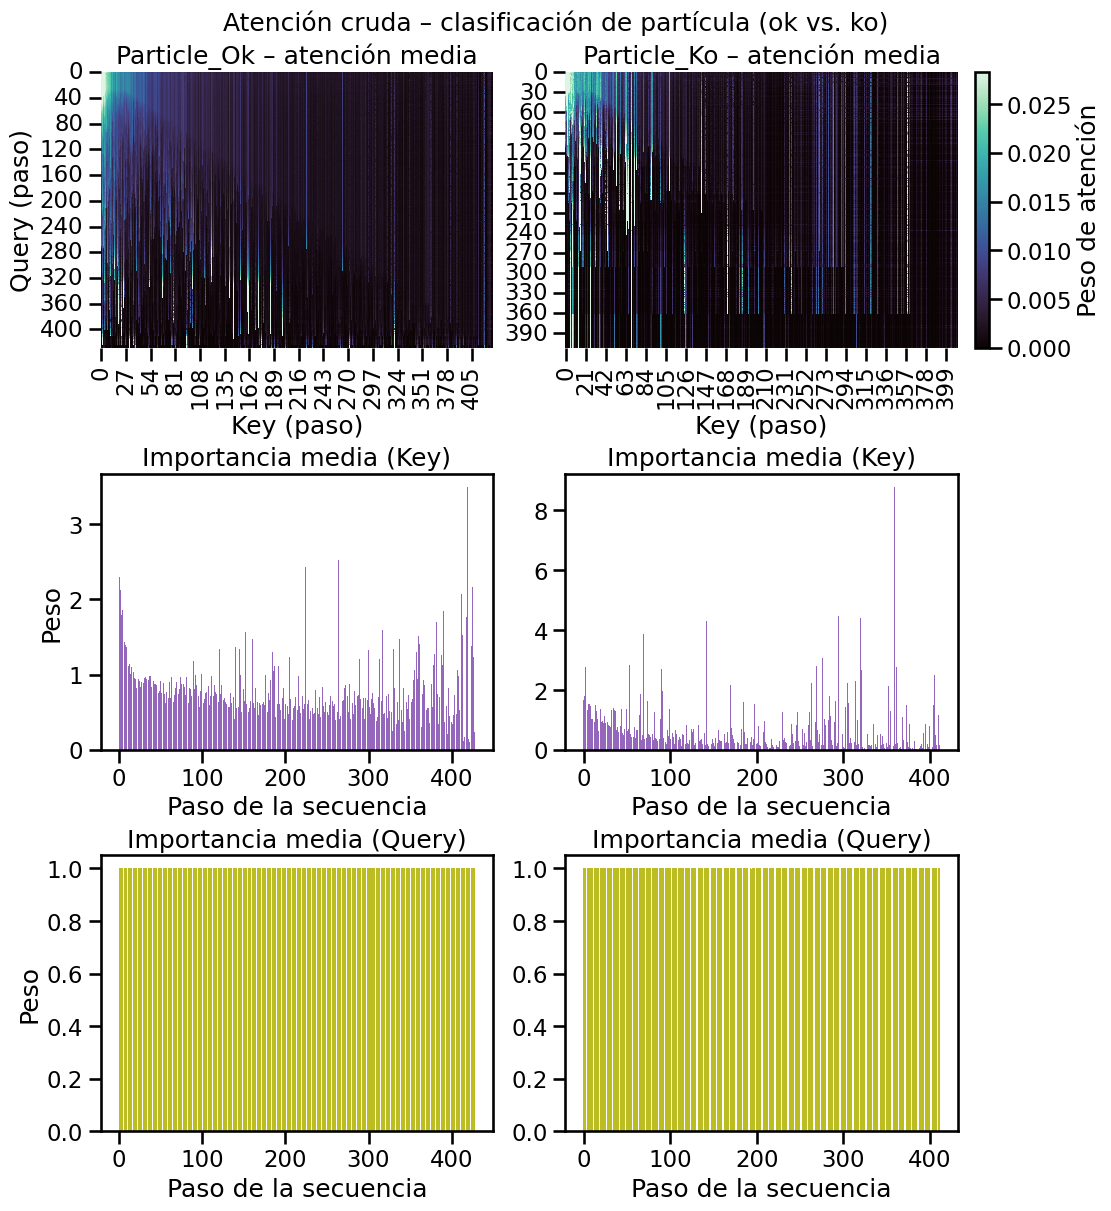

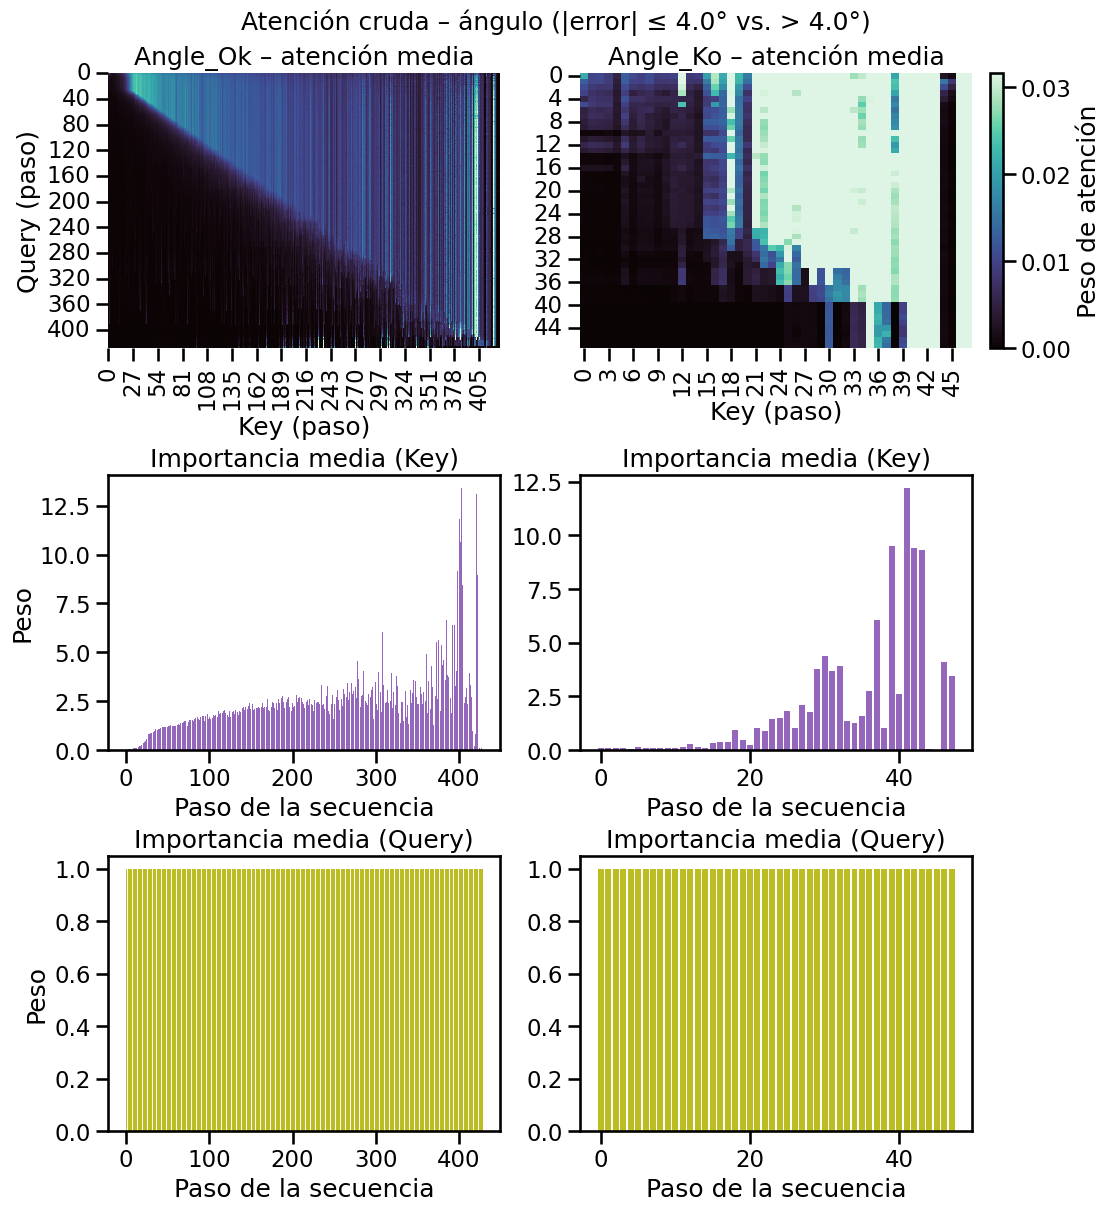

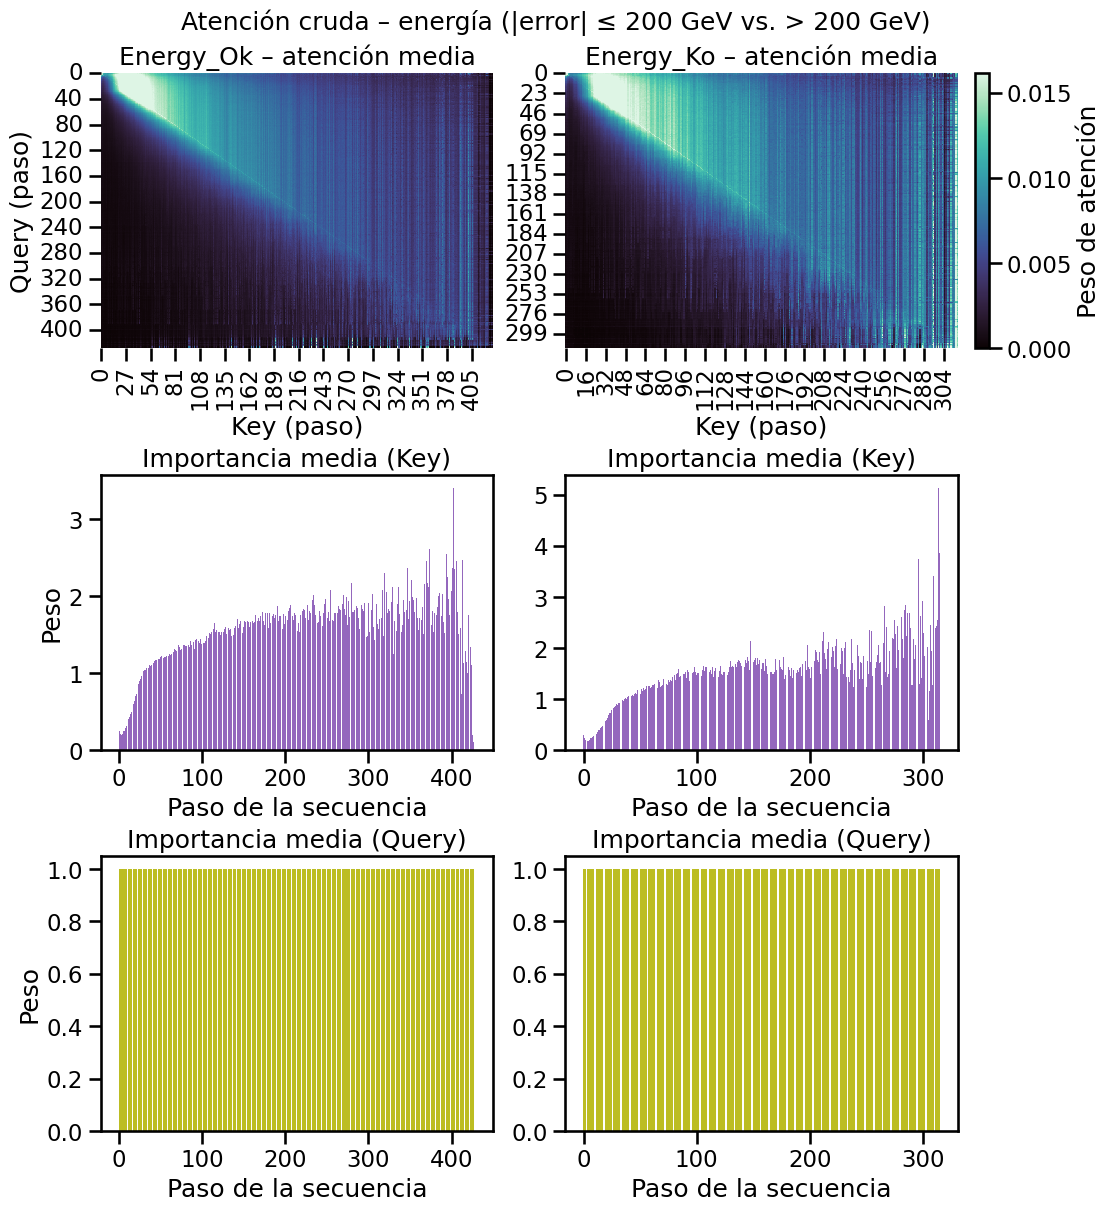

Gráficas y mapas de atención guardados en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts\diagnostics


In [ ]:
particle_summaries = {
    "particle_ok": summarize_raw_attention(particle_correct_idx, "particle"),
    "particle_ko": summarize_raw_attention(particle_wrong_idx, "particle"),
}
plot_attention_grid(
    particle_summaries,
    title="Atención cruda – clasificación de partícula (ok vs. ko)",
    save_path=plots_dir / "attention_raw_particle_ok_ko.png",
)

angle_summaries = {
    "angle_ok": summarize_raw_attention(angle_ok_idx, "angle"),
    "angle_ko": summarize_raw_attention(angle_bad_idx, "angle"),
}
plot_attention_grid(
    angle_summaries,
    title=f"Atención cruda – ángulo (|error| ≤ {angle_thresh}° vs. > {angle_thresh}°)",
    save_path=plots_dir / "attention_raw_angle_ok_ko.png",
)

energy_summaries = {
    "energy_ok": summarize_raw_attention(energy_ok_idx, "energy"),
    "energy_ko": summarize_raw_attention(energy_bad_idx, "energy"),
}
plot_attention_grid(
    energy_summaries,
    title=f"Atención cruda – energía (|error| ≤ {energy_thresh:.0f} GeV vs. > {energy_thresh:.0f} GeV)",
    save_path=plots_dir / "attention_raw_energy_ok_ko.png",
)

print(f"Gráficas y mapas de atención guardados en: {plots_dir}")